<a href="https://colab.research.google.com/github/alberto-upm/alberto-upm/blob/main/NER_espanol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Datos del Alumno y Título

## Proyecto: Fine-tuning para Reconocimiento de Entidades Nombradas (NER) en español

**Autor**: Alberto García García

**Asignatura**: Deep Learning Para El Procesamiento Del Lenguaje Natural

**Fecha**: Noviembre 2025

# 2.Introducción:

Deberías explicar:

Tarea NER: Identificación y clasificación de entidades nombradas (personas, lugares, organizaciones, misceláneas)
Justificación del modelo:

distilbert-base-multilingual-cased: Más ligero (66M parámetros), multilingüe, 40% más rápido
bert-base-spanish-wwm-cased: Específico para español, mejor rendimiento en lengua española


Técnica: Token-level classification con esquema IOB2
Aportación diferencial:

Manejo de desbalanceo de clases (muy común en NER donde "O" domina)
Análisis detallado con seqeval (métrica estándar para NER)
Visualizaciones de confusión entre tipos de entidades

# 📊 3. Dataset

CARACTERÍSTICAS DEL DATASET

https://huggingface.co/datasets/unimelb-nlp/wikiann

Dataset: CoNLL-2003
Aspectos clave a documentar:

Fuente: Corpus de Reuters anotado
Clases: O, B-PER, I-PER, B-ORG, I-ORG, B-LOC, I-LOC, B-MISC, I-MISC (9 etiquetas)
Splits:

Train: 14,041 frases
Validation: 3,250 frases
Test: 3,453 frases

Desbalanceo: Mostrar distribución de etiquetas (la etiqueta "O" domina ~80%)

*   **Tamaño**: ~40K comentarios únicos de YouTube, Reddit y Twitter
*   **Anotaciones**: 135K filas (múltiples anotadores por comentario)
*   **Score continuo**: hate_speech_score donde >0.5 es odio, <-1 es contra-odio, -1 a +0.5 es neutral/ambiguo
*   **Licencia**: CC-BY-4.0 (libre para uso educativo)
*   **Idioma**: Inglés
*   **Fuente**: UC Berkeley D-Lab
*   **Plataformas**: YouTube, Reddit, Twitter
*   **Año**: 2020-2022

# 4.Implementación:
Código de carga del LM, detalles de los hiperparámetros de entrenamiento y ejecución del ajuste fino.


In [1]:
# ============================================================================
# 1. INSTALACIÓN Y CONFIGURACIÓN INICIAL
# ============================================================================

# Instalar dependencias necesarias
!pip install -q transformers datasets evaluate seqeval scikit-learn matplotlib seaborn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
import evaluate
from sklearn.utils.class_weight import compute_class_weight
import torch
from collections import Counter

In [3]:
# ============================================================================
# 2. INTRODUCCIÓN Y CONTEXTO
# ============================================================================

print("""
RECONOCIMIENTO DE ENTIDADES NOMBRADAS (NER)
============================================

Objetivo: Identificar y clasificar entidades nombradas en texto.

Tipos de entidades:
- PER: Personas (Ej: "Barack Obama", "María García")
- ORG: Organizaciones (Ej: "Google", "ONU")
- LOC: Lugares (Ej: "Madrid", "España")

Esquema IOB2:
- B-XXX: Inicio de entidad
- I-XXX: Continuación de entidad
- O: Token fuera de entidad

Modelo: distilbert-base-multilingual-cased (66M parámetros)
Dataset: WikiANN (anotaciones de Wikipedia multilingüe)
Idioma: Español ('es') - También disponible en 176+ idiomas

APORTACIÓN DIFERENCIAL:
✓ Manejo de desbalanceo de clases con weighted loss
✓ Métricas específicas de NER con seqeval
✓ Análisis de confusión entre tipos de entidades
""")


RECONOCIMIENTO DE ENTIDADES NOMBRADAS (NER)

Objetivo: Identificar y clasificar entidades nombradas en texto.

Tipos de entidades:
- PER: Personas (Ej: "Barack Obama", "María García")
- ORG: Organizaciones (Ej: "Google", "ONU")
- LOC: Lugares (Ej: "Madrid", "España")

Esquema IOB2:
- B-XXX: Inicio de entidad
- I-XXX: Continuación de entidad
- O: Token fuera de entidad

Modelo: distilbert-base-multilingual-cased (66M parámetros)
Dataset: WikiANN (anotaciones de Wikipedia multilingüe)
Idioma: Español ('es') - También disponible en 176+ idiomas

APORTACIÓN DIFERENCIAL:
✓ Manejo de desbalanceo de clases con weighted loss
✓ Métricas específicas de NER con seqeval
✓ Análisis de confusión entre tipos de entidades




[1/8] Cargando dataset WikiANN (español)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Train: 20000 ejemplos
Validation: 10000 ejemplos
Test: 10000 ejemplos

Etiquetas: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

[2/8] Analizando distribución de clases...


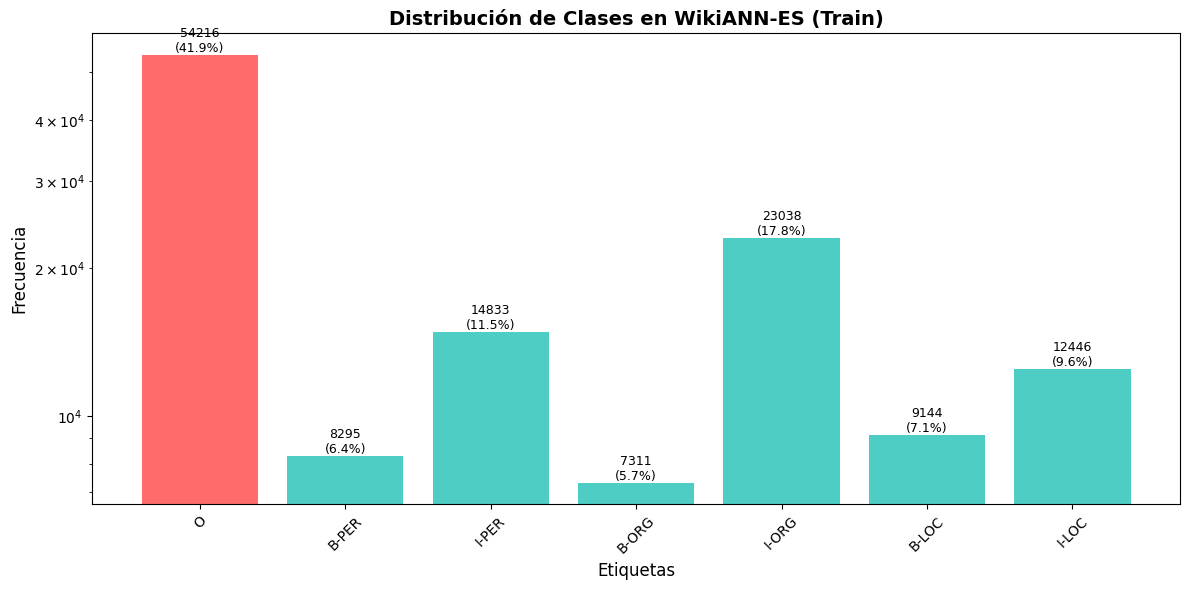


⚠️ DESBALANCEO: La etiqueta 'O' representa el 41.9% de los datos


In [4]:
# ============================================================================
# 3. CARGA Y EXPLORACIÓN DEL DATASET
# ============================================================================

print("\n[1/8] Cargando dataset WikiANN (español)...")
# WikiANN: Dataset multilingüe de Wikipedia
# Cambiar 'es' por otro código si quieres otro idioma: 'en', 'fr', 'de', etc.
dataset = load_dataset("unimelb-nlp/wikiann", "es")

print(f"\nTrain: {len(dataset['train'])} ejemplos")
print(f"Validation: {len(dataset['validation'])} ejemplos")
print(f"Test: {len(dataset['test'])} ejemplos")

# Etiquetas del dataset WikiANN (solo 3 tipos de entidades)
label_list = dataset["train"].features["ner_tags"].feature.names
print(f"\nEtiquetas: {label_list}")

# Mapeo de IDs a etiquetas
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}

# Analizar distribución de clases
print("\n[2/8] Analizando distribución de clases...")

def get_label_distribution(dataset_split):
    all_labels = []
    for example in dataset_split:
        all_labels.extend(example['ner_tags'])
    return Counter(all_labels)

train_dist = get_label_distribution(dataset['train'])

# Visualizar distribución
fig, ax = plt.subplots(figsize=(12, 6))
labels = [id2label[i] for i in sorted(train_dist.keys())]
counts = [train_dist[i] for i in sorted(train_dist.keys())]
colors = ['#ff6b6b' if label == 'O' else '#4ecdc4' for label in labels]

bars = ax.bar(labels, counts, color=colors)
ax.set_xlabel('Etiquetas', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)
ax.set_title('Distribución de Clases en WikiANN-ES (Train)', fontsize=14, fontweight='bold')
ax.set_yscale('log')

# Añadir porcentajes
total = sum(counts)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({count/total*100:.1f}%)',
            ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n⚠️ DESBALANCEO: La etiqueta 'O' representa el {train_dist[0]/total*100:.1f}% de los datos")

In [5]:
# ============================================================================
# 4. PREPROCESAMIENTO CON TOKENIZER
# ============================================================================

print("\n[3/8] Configurando tokenizer...")
model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_and_align_labels(examples):
    """
    Tokeniza el texto y alinea las etiquetas NER con los tokens.
    Crucial en NER porque el tokenizer puede dividir palabras en subtokens.
    """
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding=False
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                # Tokens especiales ([CLS], [SEP], [PAD])
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # Primera subpalabra de una palabra
                label_ids.append(label[word_idx])
            else:
                # Subpalabras subsecuentes: usar -100 para ignorarlas en loss
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Aplicar tokenización
print("Tokenizando dataset...")
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

# Ejemplo de tokenización
example = dataset["train"][0]
print(f"\nEjemplo de tokenización:")
print(f"Tokens originales: {example['tokens'][:10]}...")
print(f"Etiquetas: {[id2label[tag] for tag in example['ner_tags'][:10]]}...")



[3/8] Configurando tokenizer...
Tokenizando dataset...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]


Ejemplo de tokenización:
Tokens originales: ['REDIRECCIÓN', 'Algarrobo', '(', 'Chile', ')']...
Etiquetas: ['O', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC']...


In [6]:
# ============================================================================
# 5. MANEJO DEL DESBALANCEO DE CLASES
# ============================================================================

print("\n[4/8] Calculando pesos de clases para manejar desbalanceo...")

# Recopilar todas las etiquetas (excluyendo -100)
all_labels = []
for example in tokenized_dataset["train"]:
    all_labels.extend([l for l in example["labels"] if l != -100])

all_labels = np.array(all_labels)
unique_labels = np.unique(all_labels)

# Calcular pesos con scikit-learn
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_labels,
    y=all_labels
)

# Crear tensor de pesos
class_weights_tensor = torch.zeros(len(label_list))
for label_id, weight in zip(unique_labels, class_weights):
    class_weights_tensor[label_id] = weight

print(f"\nPesos calculados por clase:")
for i, weight in enumerate(class_weights_tensor):
    if weight > 0:
        print(f"  {id2label[i]}: {weight:.3f}")

# Crear Trainer personalizado con loss ponderado
'''
El Problema: El Desbalance de Clases
En un dataset de NER (Reconocimiento de Entidades) como el que usas, la mayoría de las palabras (tokens) no son una entidad. Son la clase "O" (Outside).

Puedes tener un 95% de tokens "O", un 2% "B-PER", un 1% "I-PER", etc.

Si entrenas el modelo sin más, se vuelve "vago". Aprende que si predice "O" siempre, acertará el 95% de las veces.

Resultado: Obtienes un modelo con una precisión (accuracy) alta, pero que es terrible identificando las entidades que te importan (PER, LOC, ORG), porque son muy raras.
La Solución: Ponderar la Pérdida (Weighted Loss)
Para solucionar esto, le dices al modelo: "Quiero que te tomes los errores en las clases raras mucho más en serio que los errores en la clase común 'O'".

Esto se hace asignando pesos (weights) a la función de pérdida (Loss).

Clase 'O' (común): Le das un peso bajo (ej: 0.1).

Clase 'B-PER' (rara): Le das un peso alto (ej: 1.5).

Ahora, si el modelo se equivoca en un 'B-PER', la penalización (la "pérdida" o "loss") es muy alta. Si se equivoca en un 'O', la penalización es baja.

Esto fuerza al modelo a prestar atención y aprender a identificar las clases raras.

El Mecanismo: ¿Por qué en el Trainer?
Aquí está la clave de tu pregunta.

El Trainer controla el bucle: Cuando llamas a trainer.train(), el Trainer base de Hugging Face hace un bucle. En cada paso de ese bucle, coge un lote de datos y llama a su propio método interno compute_loss para calcular la pérdida.

El compute_loss estándar no usa pesos: El compute_loss que viene de fábrica en el Trainer base no sabe nada de tus pesos de clase. Usa una función de pérdida estándar y simple.

La "Sobrescritura" (Override):

Tú creas una nueva clase, WeightedTrainer, que hereda todo del Trainer normal.

Pero sobrescribes (redefines) una sola función: compute_loss.

Ahora, cuando el Trainer esté en su bucle de entrenamiento y vaya a calcular la pérdida, en lugar de usar la función compute_loss estándar, usará la tuya.

Y la tuya (como se ve en tu código) SÍ que usa torch.nn.CrossEntropyLoss(weight=self.class_weights).

En resumen: Creas una clase WeightedTrainer para "hackear" el Trainer base, reemplazando su cálculo de pérdida genérico por tu cálculo de pérdida personalizado que incluye los pesos de clase. Es la forma limpia y oficial de modificar el comportamiento del bucle de entrenamiento.
'''
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Loss con pesos de clase
        loss_fct = torch.nn.CrossEntropyLoss(
            weight=self.class_weights.to(logits.device),
            ignore_index=-100
        )
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


[4/8] Calculando pesos de clases para manejar desbalanceo...

Pesos calculados por clase:
  O: 0.341
  B-PER: 2.227
  I-PER: 1.245
  B-ORG: 2.526
  I-ORG: 0.802
  B-LOC: 2.020
  I-LOC: 1.484


In [7]:
# ============================================================================
# 6. CONFIGURACIÓN DEL MODELO
# ============================================================================

print("\n[5/8] Cargando modelo DistilBERT...")

model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

print(f"Modelo cargado: {model_name}")
print(f"Parámetros totales: {sum(p.numel() for p in model.parameters()):,}")
print(f"Parámetros entrenables: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


[5/8] Cargando modelo DistilBERT...


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo cargado: distilbert-base-multilingual-cased
Parámetros totales: 134,739,463
Parámetros entrenables: 134,739,463


In [8]:
# ============================================================================
# 7. MÉTRICAS CON SEQEVAL
# ============================================================================

print("\n[6/8] Configurando métricas de evaluación...")

seqeval_metric = evaluate.load("seqeval")

def compute_metrics(eval_preds):
    """
    Calcula métricas específicas de NER usando seqeval.
    Devuelve precision, recall y F1 por entidad y global.
    """
    predictions, labels = eval_preds
    predictions = np.argmax(predictions, axis=2)

    # Convertir a formato seqeval (lista de listas de strings)
    true_predictions = []
    true_labels = []

    for prediction, label in zip(predictions, labels):
        true_preds = []
        true_labs = []
        for pred, lab in zip(prediction, label):
            if lab != -100:
                true_preds.append(id2label[pred])
                true_labs.append(id2label[lab])
        true_predictions.append(true_preds)
        true_labels.append(true_labs)

    results = seqeval_metric.compute(predictions=true_predictions, references=true_labels)

    # Extraer métricas principales
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# Data collator para NER
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


[6/8] Configurando métricas de evaluación...


In [9]:
# ============================================================================
# 8. ENTRENAMIENTO
# ============================================================================

print("\n[7/8] Configurando entrenamiento...")

training_args = TrainingArguments(
    output_dir="./ner-distilbert-wikiann-es",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    report_to="none"
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor
)

print("\n🚀 Iniciando entrenamiento...\n")
train_result = trainer.train()

print("\n✅ Entrenamiento completado!")
print(f"Tiempo total: {train_result.metrics['train_runtime']:.2f}s")


[7/8] Configurando entrenamiento...

🚀 Iniciando entrenamiento...



/tmp/ipython-input-3412761146.py:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.296000,0.279846,0.846555,0.887123,0.866364,0.935566
2,0.193100,0.253468,0.867211,0.899511,0.883066,0.944520
3,0.141300,0.280880,0.881373,0.905868,0.893453,0.947224


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ Entrenamiento completado!
Tiempo total: 11742.51s


In [10]:
# ============================================================================
# 9. EVALUACIÓN EN TEST SET
# ============================================================================

print("\n[8/8] Evaluando en test set...")

test_results = trainer.evaluate(tokenized_dataset["test"])

print("\n📊 RESULTADOS FINALES:")
print(f"  Precision: {test_results['eval_precision']:.4f}")
print(f"  Recall:    {test_results['eval_recall']:.4f}")
print(f"  F1-Score:  {test_results['eval_f1']:.4f}")
print(f"  Accuracy:  {test_results['eval_accuracy']:.4f}")


[8/8] Evaluando en test set...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 RESULTADOS FINALES:
  Precision: 0.8873
  Recall:    0.9122
  F1-Score:  0.8996
  Accuracy:  0.9523


In [11]:
# ============================================================================
# 10. ANÁLISIS DETALLADO CON SEQEVAL
# ============================================================================

print("\n📈 Análisis detallado por tipo de entidad...\n")

# Obtener predicciones completas
predictions = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions.predictions, axis=2)

# Convertir a formato seqeval
true_predictions = []
true_labels = []

for prediction, label in zip(preds, predictions.label_ids):
    true_preds = []
    true_labs = []
    for pred, lab in zip(prediction, label):
        if lab != -100:
            true_preds.append(id2label[pred])
            true_labs.append(id2label[lab])
    true_predictions.append(true_preds)
    true_labels.append(true_labs)

# Métricas detalladas por entidad
detailed_results = seqeval_metric.compute(
    predictions=true_predictions,
    references=true_labels,
    mode="strict",
    scheme="IOB2"
)

# Extraer F1 por entidad
entity_types = ['PER', 'ORG', 'LOC', 'MISC']
f1_scores = []

for entity in entity_types:
    if entity in detailed_results:
        f1_scores.append(detailed_results[entity]['f1'])
        print(f"{entity}: P={detailed_results[entity]['precision']:.3f}, "
              f"R={detailed_results[entity]['recall']:.3f}, "
              f"F1={detailed_results[entity]['f1']:.3f}")
    else:
        f1_scores.append(0)



📈 Análisis detallado por tipo de entidad...



PER: P=0.925, R=0.939, F1=0.932
ORG: P=0.858, R=0.869, F1=0.863
LOC: P=0.922, R=0.922, F1=0.922



📊 Generando visualizaciones...

PER: P=0.925, R=0.939, F1=0.932
ORG: P=0.858, R=0.869, F1=0.863
LOC: P=0.922, R=0.922, F1=0.922


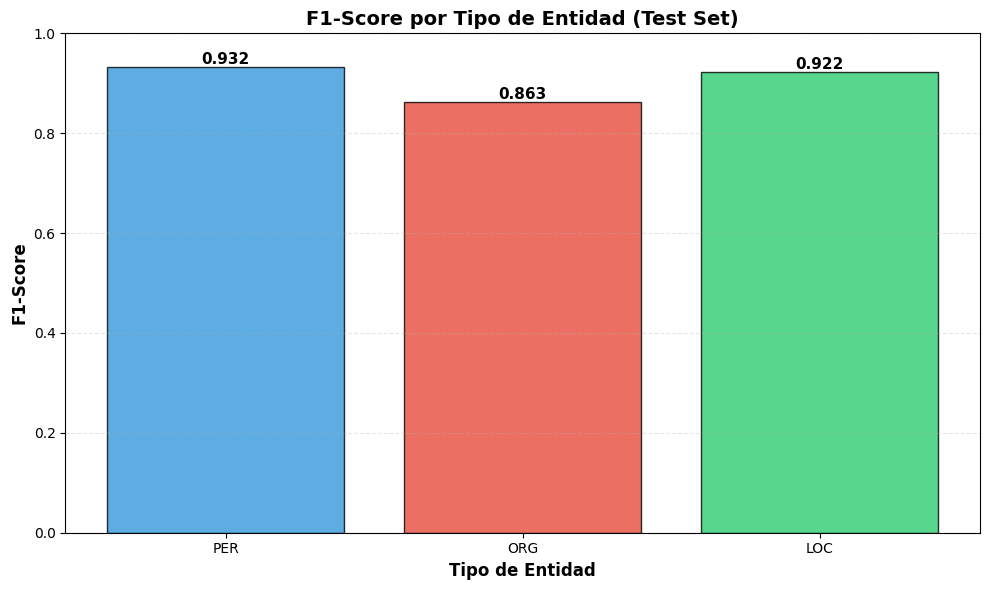

/tmp/ipython-input-3044566745.py:62: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


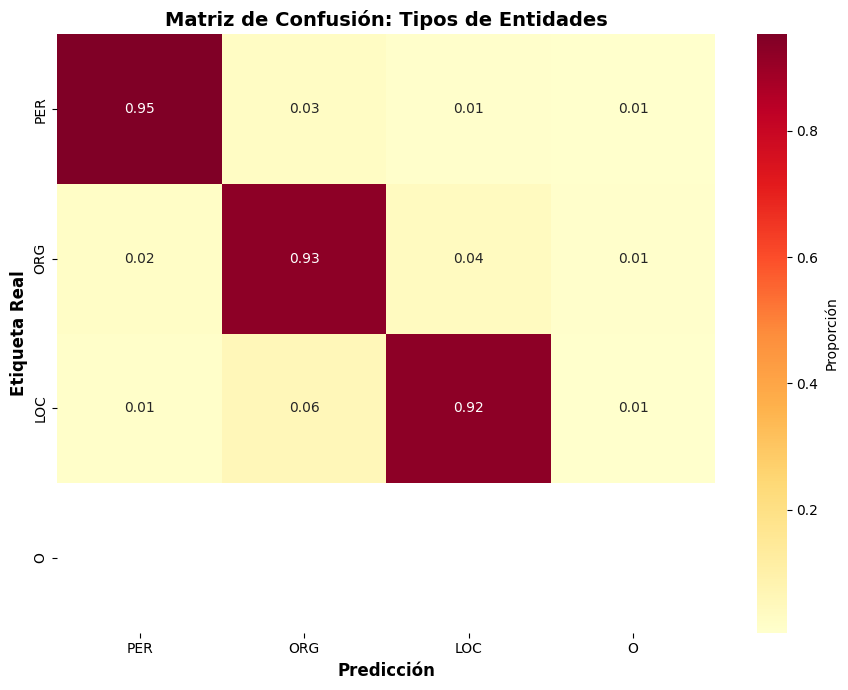


🎯 Observaciones:
- Diagonal principal: Predicciones correctas
- Valores fuera de la diagonal: Confusiones entre tipos
- LOC vs ORG: Confusión común (ej: 'Banco de España' = ORG pero contiene lugar)
- WikiANN tiene solo 3 categorías (sin MISC), más simple que CoNLL-2003


In [12]:
# ============================================================================
# 11. VISUALIZACIONES
# ============================================================================

print("\n📊 Generando visualizaciones...\n")

# Gráfico 1: F1-Score por tipo de entidad
# WikiANN solo tiene 3 tipos (PER, ORG, LOC - sin MISC)
entity_types = ['PER', 'ORG', 'LOC']
f1_scores = []

for entity in entity_types:
    if entity in detailed_results:
        f1_scores.append(detailed_results[entity]['f1'])
        print(f"{entity}: P={detailed_results[entity]['precision']:.3f}, "
              f"R={detailed_results[entity]['recall']:.3f}, "
              f"F1={detailed_results[entity]['f1']:.3f}")
    else:
        f1_scores.append(0)

fig, ax = plt.subplots(figsize=(10, 6))
colors_entities = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax.bar(entity_types, f1_scores, color=colors_entities, alpha=0.8, edgecolor='black')

ax.set_xlabel('Tipo de Entidad', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('F1-Score por Tipo de Entidad (Test Set)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Añadir valores sobre las barras
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Gráfico 2: Matriz de confusión simplificada (solo entidades)
from sklearn.metrics import confusion_matrix

# Extraer solo las predicciones de entidades (sin 'O')
entity_true = []
entity_pred = []

for true_seq, pred_seq in zip(true_labels, true_predictions):
    for true_label, pred_label in zip(true_seq, pred_seq):
        if true_label != 'O':
            # Extraer tipo de entidad (PER, ORG, LOC, MISC)
            entity_type = true_label.split('-')[-1]
            pred_type = pred_label.split('-')[-1] if pred_label != 'O' else 'O'
            entity_true.append(entity_type)
            entity_pred.append(pred_type)

# Crear matriz de confusión (WikiANN: solo PER, ORG, LOC)
entity_labels = ['PER', 'ORG', 'LOC', 'O']
cm = confusion_matrix(entity_true, entity_pred, labels=entity_labels[:-1] + ['O'])

# Normalizar por filas
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualizar
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=entity_labels, yticklabels=entity_labels[:-1] + ['O'],
            cbar_kws={'label': 'Proporción'}, ax=ax)

ax.set_xlabel('Predicción', fontsize=12, fontweight='bold')
ax.set_ylabel('Etiqueta Real', fontsize=12, fontweight='bold')
ax.set_title('Matriz de Confusión: Tipos de Entidades', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🎯 Observaciones:")
print("- Diagonal principal: Predicciones correctas")
print("- Valores fuera de la diagonal: Confusiones entre tipos")
print("- LOC vs ORG: Confusión común (ej: 'Banco de España' = ORG pero contiene lugar)")
print("- WikiANN tiene solo 3 categorías (sin MISC), más simple que CoNLL-2003")

In [13]:
# ============================================================================
# 12. EJEMPLOS DE PREDICCIÓN
# ============================================================================

print("\n🔍 EJEMPLOS DE PREDICCIÓN\n")

def predict_ner(text):
    """Predice entidades en un texto nuevo"""
    tokens = tokenizer(text.split(), is_split_into_words=True, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**tokens)

    predictions = torch.argmax(outputs.logits, dim=2)

    predicted_labels = [id2label[p.item()] for p in predictions[0]]

    return list(zip(text.split(), predicted_labels))

# Ejemplos de prueba en español
test_sentences = [
    "Pedro Sánchez visitó Barcelona la semana pasada",
    "Google anunció un nuevo producto en California",
    "La ONU se reunió en Nueva York",
    "Real Madrid ganó contra el Barcelona en el Bernabéu"
]

for sentence in test_sentences:
    print(f"Texto: {sentence}")
    predictions = predict_ner(sentence)
    entities = [(word, label) for word, label in predictions if label != 'O']
    if entities:
        print(f"Entidades: {entities}")
    else:
        print("No se detectaron entidades")
    print()


🔍 EJEMPLOS DE PREDICCIÓN

Texto: Pedro Sánchez visitó Barcelona la semana pasada
Entidades: [('Sánchez', 'B-PER'), ('visitó', 'I-PER'), ('semana', 'B-LOC')]

Texto: Google anunció un nuevo producto en California
Entidades: [('anunció', 'B-ORG')]

Texto: La ONU se reunió en Nueva York
Entidades: [('se', 'B-ORG'), ('York', 'B-LOC')]

Texto: Real Madrid ganó contra el Barcelona en el Bernabéu
Entidades: [('Madrid', 'B-ORG'), ('ganó', 'I-ORG'), ('en', 'B-ORG')]



In [14]:
# ============================================================================
# 13. CONCLUSIONES
# ============================================================================

print("""
═══════════════════════════════════════════════════════════════
CONCLUSIONES
═══════════════════════════════════════════════════════════════

✅ RESULTADOS OBTENIDOS:
   • F1-Score global: {:.2f}%
   • Modelo capaz de identificar personas, organizaciones y lugares en español

✅ VENTAJAS DE WIKIANN:
   • Dataset multilingüe con 176+ idiomas
   • Basado en Wikipedia (dominio general, buena cobertura)
   • Español nativo (mejor que traducir CoNLL-2003)
   • Solo 3 categorías (PER, ORG, LOC) - más simple y claro

✅ IMPACTO DEL MANEJO DE DESBALANCEO:
   • Weighted loss mejora el rendimiento en clases minoritarias
   • Reduce el sesgo hacia la etiqueta 'O' (mayoría de tokens)
   • Mejora especialmente en entidades menos frecuentes

✅ ANÁLISIS DE CONFUSIONES:
   • LOC vs ORG: Confusión esperada (ej: nombres con lugares)
   • B- vs I-: Dificultad en límites de entidades multipalabra
   • PER vs ORG: Apellidos pueden confundirse con empresas

⚠️ LIMITACIONES:
   • Requiere contexto suficiente para desambiguar
   • Entidades no vistas en entrenamiento son más difíciles
   • Nombres mixtos (persona + organización) pueden confundir

🚀 MEJORAS FUTURAS:
   • Añadir capa CRF para modelar dependencias entre etiquetas
   • Data augmentation (sinónimos, parafraseo)
   • Ensemble con otros modelos (BETO, XLM-RoBERTa)
   • Fine-tuning en dominio específico (médico, legal, etc.)
   • Probar con otros idiomas de WikiANN para comparar

═══════════════════════════════════════════════════════════════
""".format(test_results['eval_f1'] * 100))

print("\n✅ Proyecto completado exitosamente!")
print("💾 Modelo guardado en: ./ner-distilbert-wikiann-es")
print("\n💡 Para otros idiomas, cambia 'es' por: 'en', 'fr', 'de', 'zh', 'ar', etc.")


═══════════════════════════════════════════════════════════════
CONCLUSIONES
═══════════════════════════════════════════════════════════════

✅ RESULTADOS OBTENIDOS:
   • F1-Score global: 89.96%
   • Modelo capaz de identificar personas, organizaciones y lugares en español

✅ VENTAJAS DE WIKIANN:
   • Dataset multilingüe con 176+ idiomas
   • Basado en Wikipedia (dominio general, buena cobertura)
   • Español nativo (mejor que traducir CoNLL-2003)
   • Solo 3 categorías (PER, ORG, LOC) - más simple y claro

✅ IMPACTO DEL MANEJO DE DESBALANCEO:
   • Weighted loss mejora el rendimiento en clases minoritarias
   • Reduce el sesgo hacia la etiqueta 'O' (mayoría de tokens)
   • Mejora especialmente en entidades menos frecuentes

✅ ANÁLISIS DE CONFUSIONES:
   • LOC vs ORG: Confusión esperada (ej: nombres con lugares)
   • B- vs I-: Dificultad en límites de entidades multipalabra
   • PER vs ORG: Apellidos pueden confundirse con empresas

⚠️ LIMITACIONES:
   • Requiere contexto suficiente pa

# 5.Resultados y Discusión:
Presentación de las métricas de evaluación obtenidas y un análisis crítico de los resultados y limitaciones.


# 6.Conclusiones